# Predicting Survivors of the Titanic

The purpose of this project is to create a model that predicts whether a passenger survived the sinking of the Titanic based on passenger information.

##### Importing libraries:

In [8]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
from matplotlib import pyplot as plt
import sys
!{sys.executable} -m pip install "ethnicolr == 0.2.0"
from ethnicolr import *
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import sklearn.metrics
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.utils import shuffle
import statsmodels.api as sm
import sklearn.discriminant_analysis
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier

  Using cached https://files.pythonhosted.org/packages/97/ec/ed4d5930059c77c0bab4d101580691d137b5b891020ae5a2931c89983a19/ethnicolr-0.2.0.tar.gz
  Using cached https://files.pythonhosted.org/packages/5e/10/aa32dad071ce52b5502266b5c659451cfd6ffcbf14e6c8c4f16c0ff5aaab/Keras-2.2.4-py2.py3-none-any.whl
  Stored in directory: C:\Users\Nolan\AppData\Local\pip\Cache\wheels\3f\66\03\d8f060c6c41c32918f2c26936d73717c8d653047914499a397
Successfully built ethnicolr


Using TensorFlow backend.


### Initial Data Exploration

Loading Data:

In [10]:
df = pd.read_csv('C:/Datasets/TitanicTrain.csv')
test = pd.read_csv('C:/Datasets/TitanicTest.csv')
test.insert(1,'Survived',np.NaN)

The training dataset is about twice as large as the test data set.

In [50]:
df.shape[0]

891

In [51]:
test.shape[0]

418

Below the list of features and the dataframe are displayed.

In [11]:
variables = list(df)
print(variables)

['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']


In [16]:
df.head(20)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


## Feature Extraction

#### Functions for Feature Extraction from Passenger Name

The passenger names contain much information that can be extracted into new features. First the titles, which always end in a period, can be extracted with the following function.

In [13]:
def title(dataframe):
    dataframe['Title'] = dataframe['Name'].str.extract(r'((?<=, ).{1,12}?\.)', expand=False)
    dataframe['Name'] = dataframe['Name'].str.replace(r'(, .{1,12}?\. )', ', ').str.strip()

The maiden name, which is in parentheses, is extracted with this function.

In [14]:
def maidenname(dataframe):
    maiden = dataframe['Name'].str.extract(r'((?<=\().+(?=\)))',expand=False)
    dataframe['Maiden Name']=np.where(pd.isnull(maiden),dataframe['Name'],maiden)
    dataframe['Name'] = dataframe['Name'].str.replace(r'( \(.+\))', '').str.strip()

The nicknames, which are in quotes, are extracted as follows.

In [15]:
def nickname(dataframe):
    name = dataframe['Name']
    maiden = dataframe['Maiden Name']
    dataframe['Nickname'] = np.where(np.logical_or(name.str.contains('"'),maiden.str.contains('"')),1,0)
    dataframe['Name'] = name.str.replace(r'( )?".+"','').str.strip()
    dataframe['Maiden Name'] = maiden.str.replace(r'( )?".+"','').str.strip()
    dataframe['Maiden Name'] = np.where(maiden=='',name,maiden)

The first, middle, and last name can then be split, for both the name and maiden name. This function is more complex because sometimes there is no middle name, and some names have a suffix.

In [17]:
def splitnames(dataframe):
    def parsenames(string):
        if ',' in string:
            comma = string.index(',')
            lastname = string[:comma]
            firstname = None
            middlename = None
            if string[comma+2:]:
                firstmiddle = string[comma+2:].split(' ')
                firstname = firstmiddle[0]
                if len(firstmiddle) > 2:
                    if firstmiddle[-1] not in ['Sr', 'Jr', 'II', 'III', 'IV']:
                        middlename = ' '.join(firstmiddle[1:])
                    else:
                        middlename = ' '.join(firstmiddle[1:-1])
                elif len(firstmiddle) == 2:
                    if firstmiddle[1] not in ['Sr', 'Jr', 'II', 'III', 'IV']:
                        middlename = firstmiddle[1]
        else:
            names = string.split(' ')
            firstname = names[0]
            lastname = None
            middlename = None
            if len(names)>1:
                lastname = names[-1]
            if len(names)>2:
                middlename = ' '.join(names[1:-1])
        return (firstname,middlename,lastname)
    def fillnames(name,maidenname):
        names = parsenames(name)
        maidennames = parsenames(maidenname)
        first = ''
        middle = ''
        maidenmiddle = ''
        maidenlast = ''
        if names[0]:
            first = names[0]
        if names[1] and len(names[1]) > 1:
            middle = names[1]
        last = names[2]
        maidenfirst = maidennames[0]
        if maidennames[1] and len(maidennames[1]) > 1:
            maidenmiddle = maidennames[1]
        if maidennames[2]:
            maidenlast = maidennames[2]
        return pd.Series([first, middle, last, maidenfirst, maidenmiddle, maidenlast])
    dataframe[['First Name','Middle Name','Last Name','Maiden First Name','Maiden Middle Name','Maiden Last Name']]=\
        dataframe.apply(lambda row:fillnames(row['Name'],row['Maiden Name']),axis=1)

The name can be used to predict the ethnicity, using the ethnicolr package. In addition, this crude function is used to further subdivide the British ethnicity into British and Irish, based on syllables common in Irish last names.

In [18]:
irishsyllables=[['Mac','Mc',"O'",'Fitz'],
                ['fitz','mac','don','ees','een','eer','oon','oy','gh','dh','enn','ay','oe'],
                ['ne','uire','be','len','han','nan','lan','gan','non','hon','yan','ien','van','nn',
                 'thy','ery','dy','ley','ney','lly','hy','fy','erty','oy','ay','mack','ell','oll',
                 'wyer','yng','nna','ara','ea'],
                ['clark','thorn','well','hoyt','vell','stan','for','worth','green','mann','van ','nott','ton','town',
                 'ville','uck','ight','long','gask','shell','lane','bery','berry','thorp','throp','naught','hay','pay',
                 'ham','sell','bon','gray','grey']]

def checkirish(string):
    count = 0
    for x in irishsyllables[0]:
        if string[:len(x)]==x:
            count+=1
    for x in irishsyllables[1]:
        if x in string:
            count +=1
    for x in irishsyllables[2]:
        if string[-1*len(x):]==x:
            count+=1
    for x in irishsyllables[3]:
        if x in string.lower():
            count -=1
    if count > 0:
        return True
    else:
        return False

The ethnicities are relabeled for simplicity.

In [19]:
def relabelethnicity(dataframe,racecolumn,namecolumn):
    def newlabel(race,lastname):
        if 'British' in race:
            if checkirish(lastname):
                return 'Irish'
            else:
                return 'British'
        elif 'Japanese' in race:
            return 'EastAsian'
        elif 'Africans' in race:
            return 'African'
        elif 'Indian' in race:
            return 'Indian'
        else:
            return race.split(',')[-1]
    dataframe[racecolumn]=dataframe.apply(lambda row: newlabel(row[racecolumn],row[namecolumn]),axis=1)

Functions are defined to create features for family ethnicity (based on name) and birth ethnicity (based on maiden name if available).

In [20]:
def familyethnicity(dataframe):
    pred_wiki_name(dataframe,'Last Name','First Name')
    dataframe.rename(columns={'race':'Family Race'},inplace=True)
    relabelethnicity(dataframe, 'Family Race','Last Name')

def birthethnicity(dataframe):
    pred_wiki_name(dataframe, 'Maiden Last Name', 'Maiden First Name')
    dataframe.rename(columns={'race': 'Birth Race'}, inplace=True)
    relabelethnicity(dataframe, 'Birth Race','Maiden Last Name')

The title (prefix) for females indicates marital status sometimes. This can be extracted as follows.

In [21]:
def femalemarital(dataframe):
    married = ['Mrs.','Mme.','Lady.','the Countess.']
    unmarried = ['Miss.','Mlle.']
    dataframe['Female Marital'] = np.where(dataframe['Title'].isin(married),0.5,
                                           np.where(dataframe['Title'].isin(unmarried),-0.5,0))

Titles can also indicate profession. The professions will be grouped into: Unknown, Nobility, Clergy, Doctor, and Military.

In [22]:
def profession(dataframe):
    dataframe['Profession']='Unknown'
    dataframe.loc[dataframe['Title'].isin(['Sir.', 'Lady.', 'Lord.', 'Don.',
                                           'Dona.', 'the Countess.', 'Jonkheer']),'Profession']='Nobility'
    dataframe.loc[dataframe['Title'].isin(['Rev.', 'Minister.', 'Fr.', 'Pr.']),'Profession'] = 'Clergy'
    dataframe.loc[dataframe['Title'] == 'Dr.','Profession'] = 'Doctor'
    dataframe.loc[dataframe['Title'].isin(['Capt.', 'Major.', 'Col.']),'Profession'] = 'Military'

The title "Master" is used for male children. This may be useful in age imputation.

In [23]:
def master(dataframe):
    dataframe['Master']=np.where(dataframe['Title']=='Master.',1,0)

#### Functions for Feature Extraction from Ticket Number

First the ticket number is split into prefix and number.

In [24]:
def splitticket(dataframe):
    dataframe['Ticket']=dataframe['Ticket'].str.strip()
    dataframe['Ticket Number']=dataframe['Ticket'].str.split().str[-1]
    dataframe['Ticket Prefix']=np.where(dataframe['Ticket'].str.contains(' '),
        dataframe['Ticket'].str.split().str[:-1].str.join('').str.upper().str.replace('\.',
                                                    '').str.replace('/','').str.replace('STON','SOTON'),'No Prefix')
    dataframe['Ticket Prefix']=np.where(dataframe['Ticket'].str.contains('LINE'),'LINE',dataframe['Ticket Prefix'])
    dataframe['Ticket Number'] = np.where(dataframe['Ticket'].str.contains('LINE'), 0, dataframe['Ticket Number'])
    dataframe['Ticket Number'] = dataframe['Ticket Number'].astype('int')

A list of unique ticket prefixes is generated. A sorted version of the list is defined below for later use.

In [36]:
dfcopy = df[:]
splitticket(dfcopy)
dfcopy['Ticket Prefix'].unique()

array(['A5', 'PC', 'SOTONO2', 'No Prefix', 'PP', 'CA', 'SCPARIS', 'SCA4',
       'A4', 'SP', 'SOC', 'WC', 'SOTONOQ', 'WEP', 'C', 'SOP', 'FA',
       'LINE', 'FCC', 'SWPP', 'SCOW', 'PPP', 'SC', 'SCAH', 'AS',
       'SCAHBASLE', 'SOPP', 'FC', 'CASOTON'], dtype=object)

In [37]:
ticketprefixes = ['A2','A4','A5','AQ3','AQ4','AS','C','CA','CASOTON','FA','FC','FCC','LINE','LP','PC','PP','PPP',
                  'SC','SCA3','SCA4','SCAH','SCAHBASLE','SCOW','SCPARIS','SOC','SOP','SOPP','SOTONO2','SOTONOQ',
                  'SP','SWPP','WC','WEP','No Prefix']

The ticket number is turned into a categorical feature by binning. Bins are defined based on the histogram below.

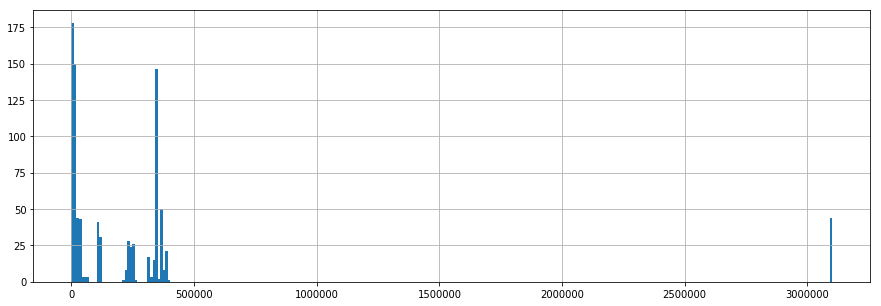

In [34]:
dfcopy['Ticket Number'].hist(bins=300, figsize=(15,5))

In [25]:
def bintickets(dataframe):
    bins = pd.IntervalIndex.from_tuples([(-1,100000),(100001,200000),(200001,260000),(260001,400000),(400001,4000000)])
    dataframe['Ticket Bin']=pd.cut(dataframe['Ticket Number'],bins)

#### Other Features

Fare is converted to a categorical feature by binning.

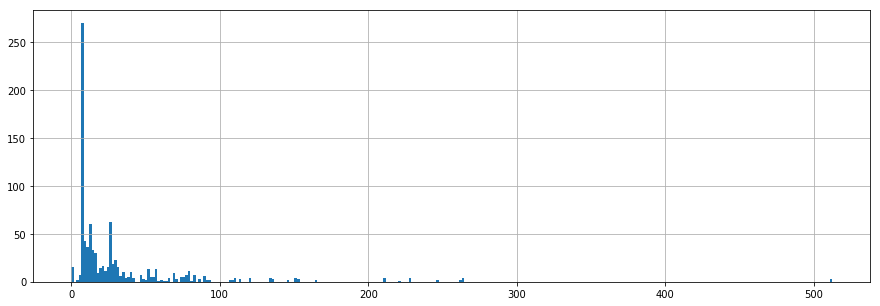

In [35]:
df['Fare'].hist(bins=300,figsize=(15,5))

In [38]:
def binfare(dataframe):
    bins =[-1,6,12,19,44,68,100,200,300,600]
    dataframe['Fare']=dataframe['Fare'].astype('float')
    dataframe['Fare Bin']=pd.cut(dataframe['Fare'],bins)

The deck can be extracted from the cabin number.

In [39]:
def deck(dataframe):
    dataframe['Deck']=np.where(pd.notnull(dataframe['Cabin']),dataframe['Cabin'].str[0],np.NaN)

### Defining Categorical Variables

In [40]:
def categorize(dataframe):
    dataframe['Sex'] = dataframe['Sex'].astype(CategoricalDtype(categories=['male', 'female'], ordered=False))
    racetype = CategoricalDtype(categories=['African', 'British', 'EastAsian', 'EastEuropean', 'French', 'Germanic',
                            'Hispanic', 'Indian', 'Irish', 'Italian', 'Jewish', 'Muslim', 'Nordic'],ordered=False)
    dataframe['Family Race'] = dataframe['Family Race'].astype(racetype)
    dataframe['Birth Race'] = dataframe['Birth Race'].astype(racetype)
    dataframe['Embarked'] = dataframe['Embarked'].astype(CategoricalDtype(categories=['S', 'C', 'Q'], ordered=False))
    dataframe['Profession'] = dataframe['Profession'].astype(CategoricalDtype(categories=['Clergy', 'Doctor',
                                                                    'Military','Nobility', 'Unknown'], ordered=False))
    dataframe['Ticket Prefix'] = dataframe['Ticket Prefix'].astype(CategoricalDtype(categories=ticketprefixes,
                                                                                    ordered=False))
    dataframe['Deck'] = dataframe['Deck'].astype(CategoricalDtype(categories=['A', 'B', 'C', 'D', 'E', 'F', 'G',
                                                                              'T', 'Unknown'],ordered=False))

### Dummy Coding

In [41]:
def dummies(dataframe):
    dataframe['Female'] = pd.get_dummies(dataframe['Sex'])['female']
    familyraces = pd.get_dummies(dataframe['Family Race'])
    familyraces = familyraces.rename(columns={x: x + ' Family' for x in list(familyraces)})
    newdataframe = pd.concat([dataframe, familyraces, pd.get_dummies(dataframe['Birth Race']),
                              pd.get_dummies(dataframe['Profession']),pd.get_dummies(dataframe['Embarked'])], axis=1)
    newdataframe=newdataframe.rename(columns={'S':'Southhampton','Q':'Queenstown','C':'Cherbourg'})
    newdataframe = pd.concat([newdataframe, pd.get_dummies(dataframe['Deck']),
                              pd.get_dummies(dataframe['Pclass'])], axis=1)
    newdataframe = newdataframe.rename(columns={1: '1', 2: '2', 3: '3'})
    return newdataframe

### Initial Pre-Processing

Now that all the feature extraction functions have been created, they can be applied to the test and training datasets. (Dummy coding is done after imputation).

In [42]:
def nameprocess(dataframe):
    title(dataframe)
    maidenname(dataframe)
    nickname(dataframe)
    splitnames(dataframe)
    familyethnicity(dataframe)
    birthethnicity(dataframe)
    femalemarital(dataframe)
    profession(dataframe)
    master(dataframe)
    deck(dataframe)
    splitticket(dataframe)
    bintickets(dataframe)
    categorize(dataframe)

In [43]:
nameprocess(df)
nameprocess(test)

W0809 16:15:51.077059 22524 deprecation_wrapper.py:119] From C:\Users\Nolan\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0809 16:15:51.123640 22524 deprecation_wrapper.py:119] From C:\Users\Nolan\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0809 16:15:51.123640 22524 deprecation_wrapper.py:119] From C:\Users\Nolan\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0809 16:15:51.228458 22524 deprecation_wrapper.py:119] From C:\Users\Nolan\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0809 16:15:51.246877 22524 deprecation.py:506

In [44]:
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Maiden Last Name,Family Race,Birth Race,Female Marital,Profession,Master,Deck,Ticket Number,Ticket Prefix,Ticket Bin
0,1,0,3,"Braund, Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,Braund,British,British,0.0,Unknown,0,NaN,21171,A5,"(-1, 100000]"
1,2,1,1,"Cumings, John Bradley",female,38.0,1,0,PC 17599,71.2833,...,Thayer,British,British,0.5,Unknown,0,C,17599,PC,"(-1, 100000]"
2,3,1,3,"Heikkinen, Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,Heikkinen,Jewish,Jewish,-0.5,Unknown,0,NaN,3101282,SOTONO2,"(400001, 4000000]"
3,4,1,1,"Futrelle, Jacques Heath",female,35.0,1,0,113803,53.1000,...,Peel,French,British,0.5,Unknown,0,C,113803,No Prefix,"(100001, 200000]"
4,5,0,3,"Allen, William Henry",male,35.0,0,0,373450,8.0500,...,Allen,Irish,Irish,0.0,Unknown,0,NaN,373450,No Prefix,"(260001, 400000]"
5,6,0,3,"Moran, James",male,NaN,0,0,330877,8.4583,...,Moran,British,British,0.0,Unknown,0,NaN,330877,No Prefix,"(260001, 400000]"
6,7,0,1,"McCarthy, Timothy J",male,54.0,0,0,17463,51.8625,...,McCarthy,Irish,Irish,0.0,Unknown,0,E,17463,No Prefix,"(-1, 100000]"
7,8,0,3,"Palsson, Gosta Leonard",male,2.0,3,1,349909,21.0750,...,Palsson,British,British,0.0,Unknown,1,NaN,349909,No Prefix,"(260001, 400000]"
8,9,1,3,"Johnson, Oscar W",female,27.0,0,2,347742,11.1333,...,Berg,British,British,0.5,Unknown,0,NaN,347742,No Prefix,"(260001, 400000]"
9,10,1,2,"Nasser, Nicholas",female,14.0,1,0,237736,30.0708,...,Achem,British,African,0.5,Unknown,0,NaN,237736,No Prefix,"(200001, 260000]"


## Imputation

It is evident that some features require imputation.

In [53]:
np.sum(pd.isnull(df), axis=0)+np.sum(pd.isnull(test), axis=0)

PassengerId              0
Survived               418
Pclass                   0
Name                     0
Sex                      0
Age                    263
SibSp                    0
Parch                    0
Ticket                   0
Fare                     1
Cabin                 1014
Embarked                 2
Title                    0
Maiden Name              0
Nickname                 0
First Name               0
Middle Name              0
Last Name                0
Maiden First Name        0
Maiden Middle Name       0
Maiden Last Name         0
Family Race              0
Birth Race               0
Female Marital           0
Profession               0
Master                   0
Deck                  1014
Ticket Number            0
Ticket Prefix            0
Ticket Bin               0
dtype: int64

For imputation purposes, we will combine the test and training sets.

In [52]:
combined = pd.concat([df,test],ignore_index=True)

First, impute the 3rd class fare for the one passenger with the missing value. Imputation is performed by taking the mean of fares from the same passenger class. Then the binned fares are repopulated.

In [54]:
thirdclassfare = combined.groupby(['Pclass']).mean()['Fare'].iloc[-1]
def imputefare(dataframe):
    dataframe['Fare']=np.where(pd.isnull(dataframe['Fare']),thirdclassfare,dataframe['Fare'])
imputefare(combined)
binfare(combined)

Next is a function to calculate missing embarkation using the mode for passengers with the same fare bin and passenger class.

In [55]:
FareGroup = combined.groupby(['Pclass','Fare Bin'])['Embarked'].agg(lambda x:x.value_counts().index[0])
def imputeembark(dataframe):
    def fillembark(classcolumn,farecolumn,embarkcolumn):
        if not isinstance(embarkcolumn,str):
            return FareGroup[(classcolumn,farecolumn)]
        else:
            return embarkcolumn
    dataframe['Embarked']=dataframe.apply(lambda row:fillembark(row['Pclass'],
                                                                row['Fare Bin'],row['Embarked']),axis=1)

The following function imputes the deck from passenger class, embarkation, ticket prefix, and ticket number. The mode for passengers with the same level for the above factors is used as the imputed value.

In [56]:
DeckFareGroup = combined.groupby(['Pclass','Embarked',
                              'Ticket Prefix','Ticket Bin','Fare Bin'])['Deck'].agg(lambda x:x.value_counts().index[0])
DeckGroup = combined.groupby(['Pclass','Embarked',
                              'Ticket Prefix','Ticket Bin'])['Deck'].agg(lambda x:x.value_counts().index[0])
DeckLargeGroup =combined.groupby(['Pclass','Embarked'])['Deck'].agg(lambda x:x.value_counts().index[0])

def imputedeck(dataframe):
    def filldeck(classcol,embarkcol,prefixcol,bincol,deckcol,farecol):
        if not isinstance(deckcol,str):
            if DeckFareGroup[(classcol,embarkcol,prefixcol,bincol,farecol)]=='Unknown':
                if DeckGroup[(classcol,embarkcol,prefixcol,bincol)]=='Unknown':
                    return DeckLargeGroup[(classcol,embarkcol)]
                else:
                    return DeckGroup[(classcol,embarkcol,prefixcol,bincol)]
            else:
                return DeckFareGroup[(classcol,embarkcol,prefixcol,bincol,farecol)]
        else:
            return deckcol
    dataframe['Deck']=dataframe.apply(lambda row:filldeck(row['Pclass'],row['Embarked'],
                                    row['Ticket Prefix'],row['Ticket Bin'],row['Deck'],row['Fare Bin']),axis=1)

Next relations between passengers are inferred by ticket numbers. If the ticket numbers are the same for two passengers, they are considered to have some kind of relationship. If the ticket numbers are within 2 of each other, and the last names are also the same between passengers, they are assumed to be relatives.

In [58]:
ticketsorted = combined[['PassengerId','Ticket Number','Last Name','Maiden Last Name']].sort_values(by=['Ticket Number'])
ticketsorted['Relations','Relatives']=0
ticketsorted=ticketsorted.reset_index(drop=True)

def relations():
    global ticketsorted
    group = [0]
    familygroup = [0]
    for i in range(1,len(ticketsorted)):
        if ticketsorted.loc[i,'Ticket Number']-ticketsorted.loc[i-1,'Ticket Number'] == 0 and i<len(ticketsorted)-1:
            group.append(i)
        else:
            if ticketsorted.loc[i,'Ticket Number']-ticketsorted.loc[i-1,'Ticket Number'] ==0 and i==len(ticketsorted)-1:
                group.append(i)
            else:
                ticketsorted.loc[i, 'Relations'] = 0
            for j in group:
                ticketsorted.loc[j,'Relations']=len(group)-1
            group = [i]
        if ticketsorted.loc[i,'Ticket Number']-ticketsorted.loc[i-1,'Ticket Number'] <= 2 and i<len(ticketsorted)-1:
            familygroup.append(i)
        else:
            if ticketsorted.loc[i,'Ticket Number']-ticketsorted.loc[i-1,'Ticket Number'] <=2 and i==len(ticketsorted)-1:
                familygroup.append(i)
            for j in familygroup:
                relatives = -1
                for k in familygroup:
                    if ticketsorted.loc[j, 'Last Name']==ticketsorted.loc[k, 'Last Name'] or\
                        ticketsorted.loc[j, 'Maiden Last Name']==ticketsorted.loc[k, 'Maiden Last Name'] or \
                            ticketsorted.loc[j, 'Last Name'] == ticketsorted.loc[k, 'Maiden Last Name'] or \
                            ticketsorted.loc[j, 'Maiden Last Name'] == ticketsorted.loc[k, 'Last Name']:
                        relatives+=1
                ticketsorted.loc[j, 'Relatives']=relatives
            familygroup = [i]
    ticketsorted = ticketsorted.sort_values(by=['PassengerId']).reset_index(drop=True)
    df[['Relations','Relatives']]=ticketsorted.loc[:891,['Relations','Relatives']]
    combined[['Relations', 'Relatives']] = ticketsorted.loc[:, ['Relations', 'Relatives']]
    test[['Relations', 'Relatives']] = ticketsorted.loc[891:, ['Relations', 'Relatives']].reset_index(drop=True)

The number of distant relatives are defined as the number of relatives (determined with the function above) minus the number of parents/children and spouse/siblings. The number of distant relations is defined by the number of relations (see above) minus the number of family members.

In [59]:
def distrelations(dataframe):
    distantrelatives = dataframe['Relatives']-dataframe['Parch']-dataframe['SibSp']
    dataframe['Distant Relatives']=np.where(distantrelatives<0,0,distantrelatives)
    distantrelations = dataframe['Relations'] - dataframe['Parch'] - dataframe['SibSp']-dataframe['Distant Relatives']
    dataframe['Distant Relations'] = np.where(distantrelations < 0, 0, distantrelations)
    dataframe['Family Size']= dataframe['Distant Relatives']+dataframe['Parch']+dataframe['SibSp']

To impute age, a new feature can be created that indicates if a passenger is traveling alone. In addition a feature will be created that indicates whether someone is known to have a job or not (based on the profession feature).

In [60]:
def alone(dataframe):
    dataframe['Alone']=np.where(dataframe['SibSp']*dataframe['Parch']*dataframe['Relations']*dataframe['Relatives']==0,1,0)

In [61]:
def professional(dataframe):
    dataframe['Professional'] = np.where(dataframe['Profession'] !='Unknown', 1, 0)

Finally, age can be imputed based on marital status, 'Master' title, whether the individual is a professional, traveling alone, and the passenger class.

In [62]:
relations()
distrelations(df)
distrelations(test)
distrelations(combined)
alone(combined)
professional(combined)
AgeGroup = combined.groupby(['Female Marital','Master','Professional','Alone','Pclass'])['Age'].mean()
def imputeage(dataframe):
    def fillage(maritalcol,mastercol,profcol,alonecol,classcol,agecol):
        if np.isnan([agecol])[0]:
            return AgeGroup[(maritalcol,mastercol,profcol,alonecol,classcol)]
        else:
            return agecol
    dataframe['Age']=dataframe.apply(lambda row:fillage(row['Female Marital'],row['Master'],
                                    row['Professional'],row['Alone'],row['Pclass'],row['Age']),axis=1)

      PassengerId  Ticket Number     Last Name Maiden Last Name  \
0             598              0       Johnson          Johnson   
1             180              0       Leonard          Leonard   
2             303              0       Johnson          Johnson   
3             272              0     Tornquist        Tornquist   
4            1078              2      Phillips         Phillips   
5            1194              2      Phillips         Phillips   
6             842              3          Mudd             Mudd   
7             773              3          Mack                    
8            1062            251       Lithman          Lithman   
9             474            541        Jerwan        Thuillard   
10           1270            680       Hipkins          Hipkins   
11            546            693     Nicholson        Nicholson   
12            903            694         Jones            Jones   
13            873            695      Carlsson         Carlsso

Now imputation can be performed, along with dummy coding.

In [63]:
def imputation(dataframe):
    binfare(dataframe)
    imputeembark(dataframe)
    imputedeck(dataframe)
    alone(dataframe)
    professional(dataframe)
    imputeage(dataframe)

imputefare(test)
imputation(df)
imputation(test)
df=dummies(df)
test=dummies(test)
combined = dummies(combined)

C
C


## Exploratory Data Analysis

### Visualization

First, functions are defined to create the plots.

In [68]:
def survivalgroup(column,ax):
    percent=df.groupby(column)['Survived'].agg(lambda x:x.sum()/x.count()*100)
    if len(column)==1:
        percent.plot(kind='bar',ax=ax,legend=False)
    elif len(column)>1:
        percent.unstack().plot(kind='bar',ax=ax,legend=False)
    ax.set_ylabel('% Survived')

def survivalhist(column,secondcolumn=None,bins=None,ax=None):
    df['Histbins'] = pd.cut(column, bins)
    if not secondcolumn:
        percent=df.groupby(['Histbins'])['Survived'].agg(lambda x:x.sum()/x.count()*100)
        percent.plot(kind='bar',ax=ax,legend=False)
    else:
        percent = df.groupby(['Histbins']+secondcolumn)['Survived'].agg(lambda x: x.sum() / x.count() * 100)
        percent.unstack().plot(kind='bar',ax=ax,legend=False)
    ax.set_ylabel('% Survived')

Lists are created for the labels.

In [65]:
categoricalx = ['Pclass','Deck','Embarked','Family Race','Birth Race',
                'Sex','Female Marital','Family Size','Distant Relations','Profession','Nickname']
continuousx=['Age','Fare']
races = ['African', 'British', 'EastAsian', 'EastEuropean', 'French', 'Germanic','Hispanic', 'Indian', 'Irish',
         'Italian', 'Jewish', 'Muslim', 'Nordic']
professions = ['Clergy', 'Doctor', 'Military','Nobility', 'Unknown']
decks = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T']

The first set of plots are bar charts showing the frequency of survival by feature.

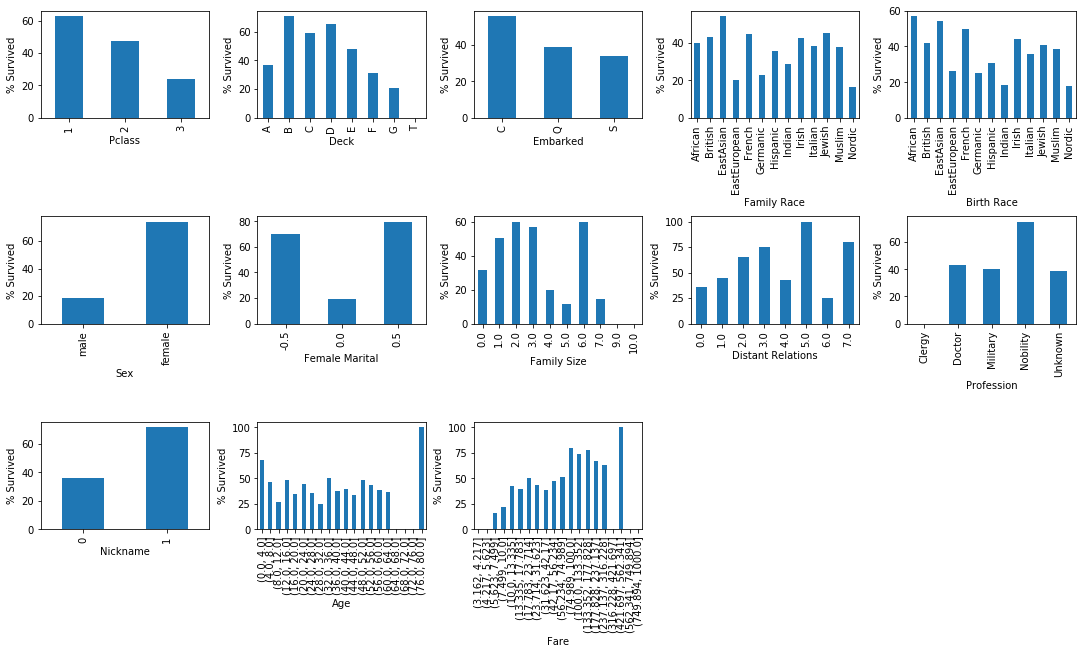

In [70]:
fig0, ax0 = plt.subplots(3,5)
fig0.delaxes(ax0[2][3])
fig0.delaxes(ax0[2][4])
for i in range(len(categoricalx)):
    survivalgroup([categoricalx[i]],ax0[i//5,i%5])
survivalhist(df['Age'],bins=np.linspace(0,80,21),ax=ax0[2,1])
survivalhist(df['Fare'],bins=np.logspace(0.5,3,21),ax=ax0[2,2])
ax0[2,1].set_xlabel('Age')
ax0[2,2].set_xlabel('Fare')
fig0.set_size_inches(15,9)
fig0.tight_layout(pad=0.4,w_pad=0.5,h_pad=0.5)

Almost all features show some effect of the feature level on survival. Sex has the clearest effect (females are much more likely to survive). For embarkation, Cherbourg passengers seem to survive more. Passenger class, deck, and fare all show trends with survival. The surprising effect is that of having a nickname. This may be just coincidental, or perhaps having a nickname recorded indicates something about one's personality that makes the person more likely to survive.

Next, the distribution of levels of different features are shown in pie charts.

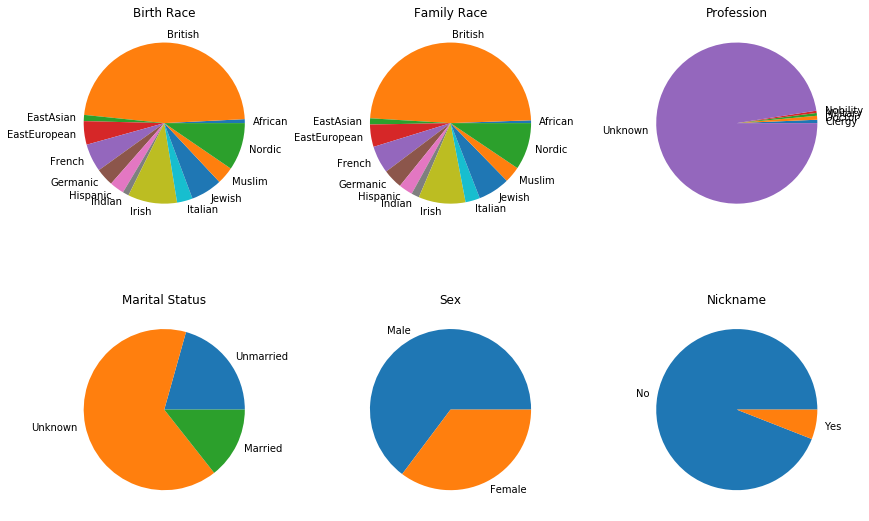

In [71]:
fig1, ax1 = plt.subplots(2,3)
ax1[0,0].set_title('Birth Race')
ax1[0,1].set_title('Family Race')
ax1[0,2].set_title('Profession')
ax1[1,0].set_title('Marital Status')
ax1[1,1].set_title('Sex')
ax1[1,2].set_title('Nickname')
ax1[0,0].pie(df.groupby(['Birth Race'])['Survived'].count(),labels=races)
ax1[0,1].pie(df.groupby(['Family Race'])['Survived'].count(),labels=races)
ax1[0,2].pie(df.groupby(['Profession'])['Survived'].count(),labels=professions)
ax1[1,0].pie(df.groupby(['Female Marital'])['Survived'].count(),labels=['Unmarried','Unknown','Married'])
ax1[1,1].pie(df.groupby(['Sex'])['Survived'].count(),labels=['Male','Female'])
ax1[1,2].pie(df.groupby(['Nickname'])['Survived'].count(),labels=['No','Yes'])
fig1.set_size_inches(12,8)
fig1.tight_layout(pad=0.4,w_pad=0.5,h_pad=0.5)

The feature levels are not uniformly distributed. However, there is some variation in most features except profession. Nickname also is quite imbalanced, which may have resulted in the apparent effect of nickname on survival.

The first set of % Survival plots may be skewed by groups with small numbers of passengers (the error will be higher for these groups). Therefore another set of plots showing the absolute number of passengers who survived and died is shown below to clarify some of the features with ambiguous effects.

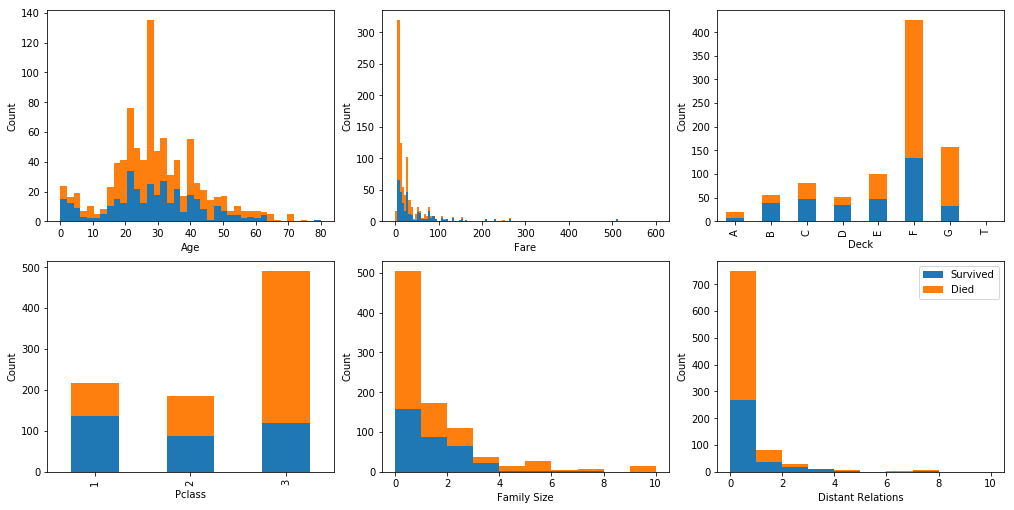

In [72]:
fig3, ax3 = plt.subplots(2,3)
ax3[0,0].hist([df.loc[df['Survived']==1,'Age'],df.loc[df['Survived']==0,'Age']],
              bins=np.linspace(0,80,40),stacked=True)
ax3[0,0].set_xlabel('Age')
ax3[0,1].hist([df.loc[df['Survived']==1,'Fare'],df.loc[df['Survived']==0,'Fare']],
              bins=np.linspace(0,600,120),stacked=True)
ax3[0,1].set_xlabel('Fare')
deckplot = pd.concat([df.groupby(['Deck'])['Survived'].apply(lambda x:(x==1).sum()),
                     df.groupby(['Deck'])['Survived'].apply(lambda x:(x==0).sum())],axis=1)
deckplot.plot.bar(ax=ax3[0,2],stacked=True,legend=False)
classplot = pd.concat([df.groupby(['Pclass'])['Survived'].apply(lambda x:(x==1).sum()),
                     df.groupby(['Pclass'])['Survived'].apply(lambda x:(x==0).sum())],axis=1)
classplot.plot.bar(ax=ax3[1,0],stacked=True, legend=False)
ax3[1,1].hist([df.loc[df['Survived']==1,'Family Size'],df.loc[df['Survived']==0,'Family Size']],
              bins=np.linspace(0,10,11),stacked=True)
ax3[1,1].set_xlabel('Family Size')
ax3[1,2].hist([df.loc[df['Survived']==1,'Distant Relations'],df.loc[df['Survived']==0,'Distant Relations']],
              bins=np.linspace(0,10,11),stacked=True)
ax3[1,2].set_xlabel('Distant Relations')
ax3[1,2].legend(['Survived','Died'])
for i in range(2):
    for j in range(3):
        ax3[i,j].set_ylabel('Count')
fig3.set_size_inches(14,7)
fig3.tight_layout(pad=0.4,w_pad=0.5,h_pad=0.5)

Here the effect of family size and distant relations becomes more evident. Many more survive if they have fewer family members or relations on board. Also, it is evident that a higher fraction of children under ~10-14 survive than older passengers.

Next, since gender had a large effect, interactions between gender and other features are explored with the following plots.

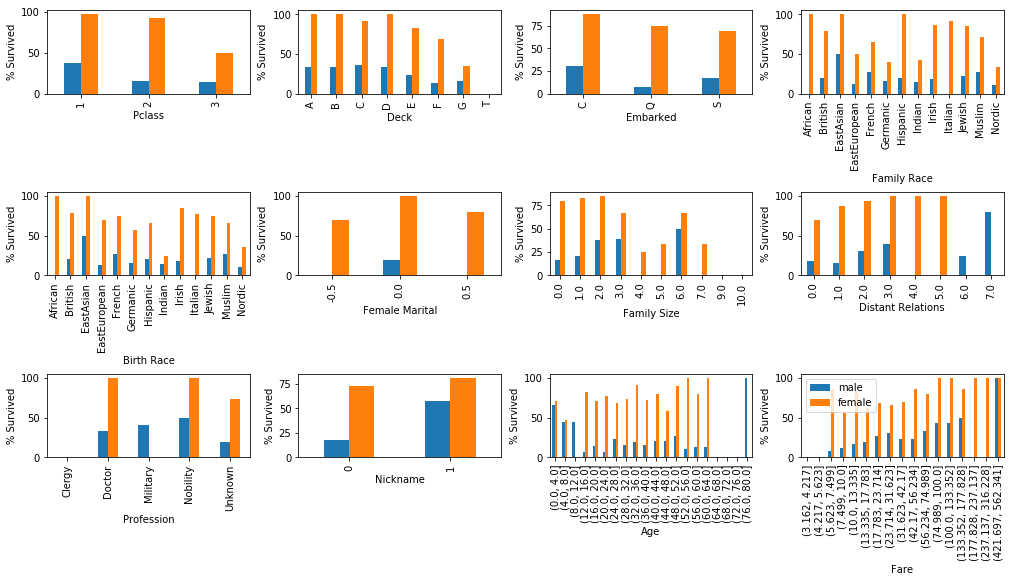

In [73]:
fig4, ax4 = plt.subplots(3,4)
categoricalx.remove('Sex')
for i in range(len(categoricalx)):
    survivalgroup([categoricalx[i],'Sex'],ax4[i//4,i%4])
survivalhist(df['Age'],['Sex'],bins=np.linspace(0,80,21),ax=ax4[2,2])
survivalhist(df['Fare'],['Sex'],bins=np.logspace(0.5,3,21),ax=ax4[2,3])
ax4[2,3].legend()
ax4[2,2].set_xlabel('Age')
ax4[2,3].set_xlabel('Fare')
fig4.set_size_inches(14,8)
fig4.tight_layout(pad=0.4,w_pad=0.5,h_pad=0.5)
categoricalx.insert(5,'Sex')

The effect of class seems to be higher for males than females. The effect of age and fare is larger for males than females. Effects of family size, profession, and race vary without an obvious pattern. Interestingly the effect of nickname is higher for males than females.

Next, interactions between class and other features are explored.

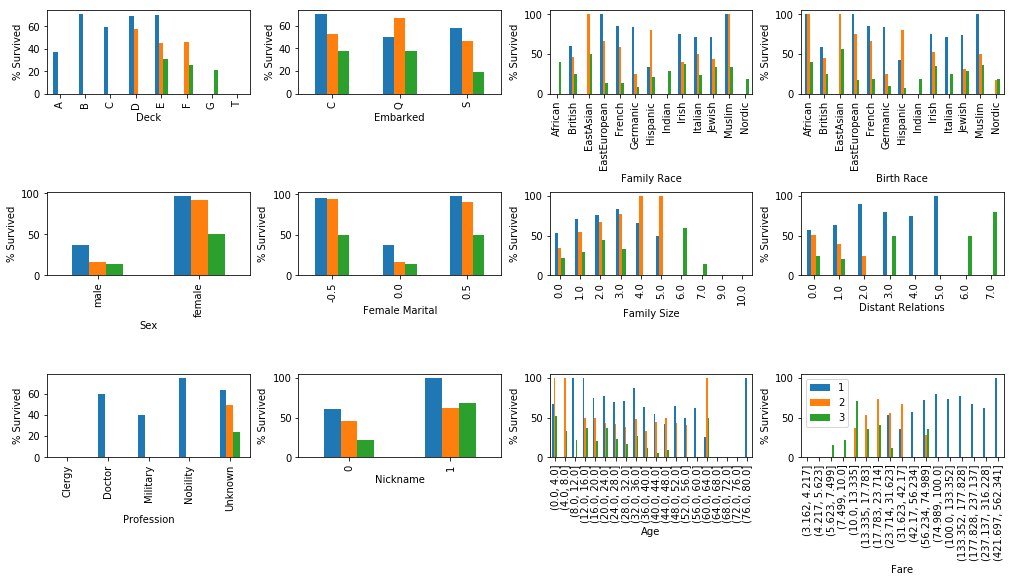

In [74]:
fig5, ax5 = plt.subplots(3,4)
categoricalx.remove('Pclass')
for i in range(len(categoricalx)):
    survivalgroup([categoricalx[i],'Pclass'],ax5[i//4,i%4])
survivalhist(df['Age'],['Pclass'],bins=np.linspace(0,80,21),ax=ax5[2,2])
survivalhist(df['Fare'],['Pclass'],bins=np.logspace(0.5,3,21),ax=ax5[2,3])
ax5[2,3].legend()
ax5[2,2].set_xlabel('Age')
ax5[2,3].set_xlabel('Fare')
fig5.set_size_inches(14,8)
fig5.tight_layout(pad=0.4,w_pad=0.5,h_pad=0.5)
categoricalx.insert(0,'Pclass')

First class passengers are generally on higher decks and paid higher fares, so the two effects are likely to be related. The interactions are not as clear for other factors.

#### Randomness of Dataset

To check if the data needs to be shuffled, the correlation between the index and continuous variables is calculated.

In [75]:
correlationlist = []
index = df.index.tolist()
for i in ['Survived','Pclass','Female','Age','SibSp','Parch','Fare']:
    variable = df.loc[:,i]
    correlationlist.append([i,np.corrcoef(index,variable)[0,1]])
print(correlationlist)

[['Survived', -0.005006660767066487], ['Pclass', -0.03514399403037977], ['Female', -0.04293888007878875], ['Age', 0.03855082908941326], ['SibSp', -0.05752683378444151], ['Parch', -0.0016520124027188355], ['Fare', 0.012658219287491225]]


There are no strong correlations, indicating that the data is not sorted by any of these factors and does not need to be randomized further.

## Transformation

The distribution of fares suggests a log transformation is appropriate, especially if a linear model is to be used. Also, since the effect of fare is mainly for males, the interaction between gender and fare will be created as a new feature. Also, since the distribution of age appears to be bimodal, age will be split into child age and adult age. A function for these transformations is defined below.

In [76]:
def transform(dataframe,agethreshold):
    # Log scale the fare
    dataframe['Log Fare'] = np.log(dataframe['Fare'] + 1)
    # Split Age
    dataframe['Child'] = np.where(dataframe['Age'] <= agethreshold, 1, 0)
    dataframe['Child Age'] = dataframe['Child'] * dataframe['Age']
    dataframe['Adult Age'] = -1 * (1 - dataframe['Child']) * dataframe['Age']
    # Log Fare x Female
    dataframe['Fare x Female']=dataframe['Female']*dataframe['Log Fare']

Also, the features will be scaled so that algorithms involving distance calculations may be applied.

In [77]:
def rescale(dataframe):
    for x in ['Log Fare','Fare','Fare x Female', 'Age', 'Child Age', 'Adult Age', 'Family Size', 'Distant Relations']:
        dataframe[x] = 0.5 * dataframe[x]/combined[x].mean()

The transformations are applied, along with adding a column for constant (column of 1s) which is required for statsmodels GLM. The age threshold for children is set to 12 based on the histograms.

In [78]:
df['Constant']=1
test['Constant']=1

transform(df,12)
transform(test,12)
transform(combined,12)
rescale(df)
rescale(test)

## Feature and Model Selection

A list of all the model features is defined below. GLM in statsmodels will require the constant feature.

In [79]:
features = ['Log Fare','1','2','Cherbourg','Queenstown','A','B','C','D','E','F','G','Nickname','African', 'EastAsian',
            'EastEuropean', 'French', 'Germanic', 'Hispanic', 'Indian', 'Irish', 'Italian', 'Jewish', 'Muslim',
            'Nordic','Female','Child','Child Age','Adult Age','Family Size','Distant Relations','Female Marital']

featuresGLM = ['Constant']+features

Some functions for evaluation of all models are defined below. The evaluations use 3 fold cross validation, based on the size of training and test data sets.

In [80]:
def testmodel(xlist, model,ROC=True):
    X = df[xlist]
    y = df['Survived']
    matrix = pd.concat([X, y], axis=1)
    model.fit(X, y)
    if ROC:
        yscores = model.predict(X)
        fpr, tpr, thresholds = sklearn.metrics.roc_curve(y, yscores)
    ypredict = model.predict(X)
    print('Accuracy: ' + str(sklearn.metrics.accuracy_score(y, ypredict)))
    print('Precision: ' + str(sklearn.metrics.precision_score(y, ypredict)))
    print('Recall: ' + str(sklearn.metrics.recall_score(y, ypredict)))
    if ROC:
        print('ROC AUC: ' + str(sklearn.metrics.roc_auc_score(y, yscores)))
    cvscore = sum(cross_val_score(model, X, y, cv=3)) / 3
    for i in range(9):
        shuffled = shuffle(matrix)
        X = shuffled[xlist]
        y = shuffled['Survived']
        cvscore += sum(cross_val_score(model, X, y, cv=3)) / 3
    cvscore = cvscore / 10
    print('CV score: ' + str(cvscore))
    if ROC:
        return fpr,tpr

def optimize(alg,xlist,griddict):
    X = df[xlist]
    y = df['Survived']
    grid = [griddict]
    model = alg
    clf = GridSearchCV(model,grid,cv=3)
    clf.fit(X,y)
    print(clf.best_params_)
    ypredict = clf.predict(X)
    print(sklearn.metrics.accuracy_score(y, ypredict))
    print(sklearn.metrics.recall_score(y, ypredict, average=None))
    print(sklearn.metrics.precision_score(y, ypredict, average=None))

### Generalized Linear Model (Logistic Regression)

In [89]:
def logistic(xlist, featurereduction = False):
    # First check for statistical significance of features using statsmodels (unregularized)
    if featurereduction:
        X = df[featuresGLM]
        y = df['Survived']
        logisticmodel = sm.GLM(y, X, family=sm.families.Binomial())
        results = logisticmodel.fit()
        print(results.summary())
    # Use sklearn regularized Logistic regression on reduced feature set
    else:
        model = LogisticRegression(solver='liblinear')
        fpr,tpr = testmodel(xlist,model)
        fig6, ax6 = plt.subplots(1,2)
        ax6[0].bar(xlist, model.coef_[0])
        ax6[0].set_xticklabels(xlist, rotation=90)
        ax6[0].set_title('Coefficients')
        ax6[1].plot(fpr, tpr)
        ax6[1].set_title('ROC Curve')
        fig6.tight_layout(pad=0.4, w_pad=0.5, h_pad=0.5)

In [84]:
logistic(featuresGLM, featurereduction= True)

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Survived   No. Observations:                  891
Model:                            GLM   Df Residuals:                      858
Model Family:                Binomial   Df Model:                           32
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -348.90
Date:                Fri, 09 Aug 2019   Deviance:                       697.80
Time:                        18:12:05   Pearson chi2:                     986.
No. Iterations:                    19   Covariance Type:             nonrobust
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Constant            -22.4060   1.77e+04     -0.001      0.999   -3.48e+04    3.47e+04
Log Fare              1.8078   

From the above results, the features can be reduced to the following list, based on accepting only features with p < 0.05.

In [85]:
reducedLR=['Log Fare','1','2','Cherbourg','Nickname','EastAsian','Italian',
            'Female','Child','Child Age','Adult Age','Family Size','Female Marital']

Accuracy: 0.8305274971941639
Precision: 0.8031746031746032
Recall: 0.7397660818713451
ROC AUC: 0.8134167385677309
CV score: 0.8234567901234568


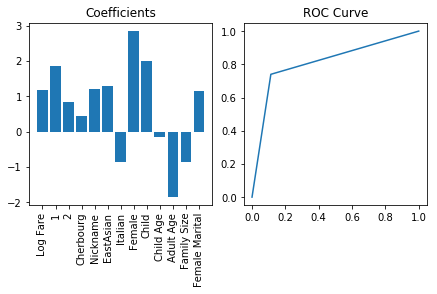

In [90]:
logistic(reducedLR, featurereduction= False)

The CV score is similar to the overall accuracy, indicating that there is not much overfitting.

### Gradient Boosted Tree

Features will be selected based on the feature importances from the full model using default hyperparameters.

Accuracy: 0.898989898989899
Precision: 0.9064516129032258
Recall: 0.8216374269005848
ROC AUC: 0.8844070558910938
CV score: 0.8195286195286196


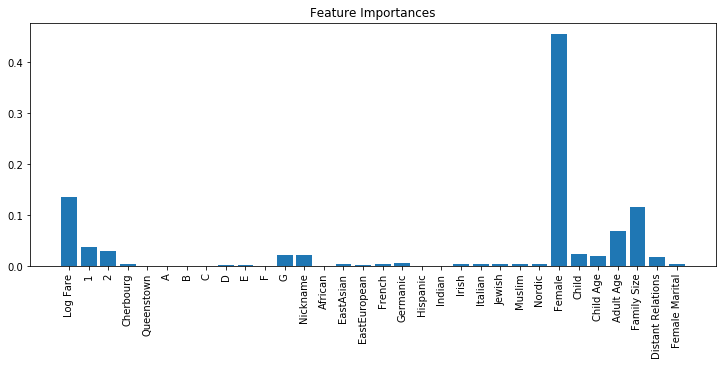

In [108]:
model = GradientBoostingClassifier()
fpr,tpr = testmodel(features,model)
fig6, ax6 = plt.subplots(1)
ax6.bar(features, model.feature_importances_)
ax6.set_xticklabels(features, rotation=90)
ax6.set_title('Feature Importances')
fig6.set_size_inches((10,5))
fig6.tight_layout(pad=0.4, w_pad=0.5, h_pad=0.5)

Based on the importances, the following features are selected.

In [109]:
reducedGB = ['Log Fare','1','2','G','Nickname','Female','Child','Child Age','Adult Age',
             'Family Size','Distant Relations']

This algorithm has a few hyperparameters that must be tuned.

In [118]:
model = GradientBoostingClassifier()
optimize(model, reducedGB, {'learning_rate':[0.01, 0.02, 0.05, 0.1, 0.2, 0.5],
                           'n_estimators':[10,20,50,100]})

{'learning_rate': 0.1, 'n_estimators': 20}
0.8507295173961841
[0.91256831 0.75146199]
[0.85494881 0.84262295]


In [124]:
model = GradientBoostingClassifier(learning_rate=0.1, n_estimators =20)
optimize(model, reducedGB, {'max_features':['log2','sqrt'],
                           'max_depth':[2, 3, 4, 5, 7, 10],
                           'min_samples_leaf':[2, 3, 4, 5, 7, 10]})

{'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 3}
0.8731762065095399
[0.94717668 0.75438596]
[0.86092715 0.8989547 ]


In [125]:
model = GradientBoostingClassifier(learning_rate=0.1, n_estimators =20, max_features='sqrt',
                                  max_depth = 5, min_samples_leaf = 3)
optimize(model, reducedGB, {'subsample':[0.5, 0.6, 0.7, 0.8, 0.9, 1]})

{'subsample': 1}
0.8720538720538721
[0.93260474 0.7748538 ]
[0.86926995 0.87748344]


In [127]:
model = GradientBoostingClassifier(max_features='sqrt',max_depth = 5, min_samples_leaf = 3,
                                   subsample=1)
optimize(model, reducedGB, {'learning_rate':[0.01, 0.02, 0.05, 0.1, 0.2, 0.5],
                           'n_estimators':[10,20,50,100]})

{'learning_rate': 0.1, 'n_estimators': 100}
0.9180695847362514
[0.96357013 0.84502924]
[0.90893471 0.93527508]


In [133]:
model = GradientBoostingClassifier(learning_rate=0.1, n_estimators =100,
                                   max_features='sqrt',subsample=1)
optimize(model, reducedGB, {'max_depth':[2, 3, 4, 5, 7, 10],
                           'min_samples_leaf':[2, 3, 4, 5, 7, 10]})

{'max_depth': 3, 'min_samples_leaf': 4}
0.8742985409652076
[0.92531876 0.79239766]
[0.87737478 0.86858974]


In [100]:
def treeboost(xlist):
    model = GradientBoostingClassifier(learning_rate=0.1,n_estimators=100, max_depth=3,
                                       min_samples_leaf=4, max_features='sqrt', subsample=1)
    fpr,tpr = testmodel(xlist,model)
    fig6, ax6 = plt.subplots(1,2)
    ax6[0].bar(xlist, model.feature_importances_)
    ax6[0].set_xticklabels(xlist, rotation=90)
    ax6[0].set_title('Feature Importances')
    ax6[1].plot(fpr,tpr)
    ax6[1].set_title('ROC Curve')
    fig6.set_size_inches((10,5))
    fig6.tight_layout(pad=0.4, w_pad=0.5, h_pad=0.5)

Accuracy: 0.8473625140291807
Precision: 0.8410596026490066
Recall: 0.7426900584795322
ROC AUC: 0.8276291822452306
CV score: 0.8307519640852975


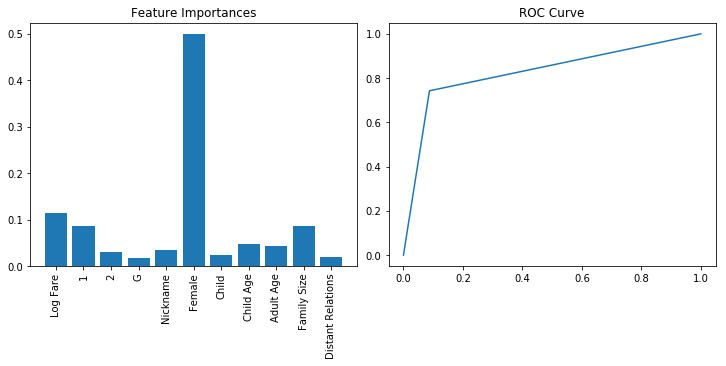

In [134]:
treeboost(reducedGB)

The CV result is similar to overall accuracy, so there is not much overfitting.

## Random Forest

Feature selection:

C:\Users\Nolan\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy: 0.9775533108866442
Precision: 0.9908536585365854
Recall: 0.9502923976608187
CV score: 0.8023569023569023


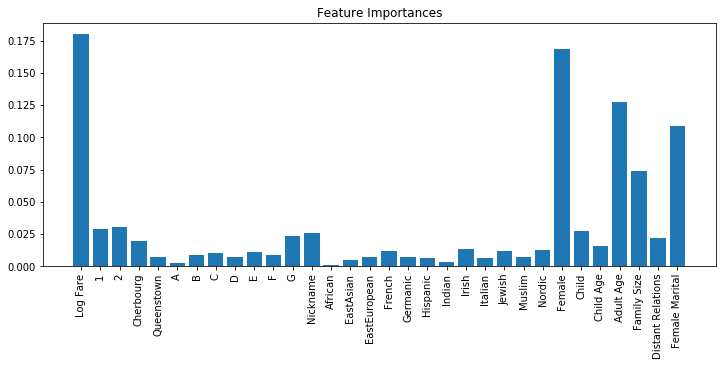

In [139]:
model = RandomForestClassifier()
testmodel(features, model,ROC=False)
fig6, ax6 = plt.subplots(1)
ax6.bar(features, model.feature_importances_)
ax6.set_xticklabels(features, rotation=90)
ax6.set_title('Feature Importances')
fig6.set_size_inches((10,5))
fig6.tight_layout(pad=0.4, w_pad=0.5, h_pad=0.5)

The reduced feature set is as follows.

In [140]:
reducedRF =['Log Fare','1','2','G','Cherbourg','Nickname','Female','Child','Child Age',
             'Adult Age','Family Size','Distant Relations','Female Marital']

Optimizing hyperparameters:

In [141]:
model = RandomForestClassifier()
optimize(model, reducedRF, {'max_depth':[2,3,5,10],'n_estimators':[20,50,70,100]})

{'max_depth': 5, 'n_estimators': 50}
0.8507295173961841
[0.91256831 0.75146199]
[0.85494881 0.84262295]


In [148]:
model = RandomForestClassifier()
optimize(model, reducedRF, {'max_depth':[4,5,6,7],'n_estimators':[40, 40, 50, 60, 70]})

{'max_depth': 6, 'n_estimators': 60}
0.8641975308641975
[0.92531876 0.76608187]
[0.86394558 0.86468647]


Accuracy: 0.8653198653198653
Precision: 0.875
Recall: 0.7573099415204678
CV score: 0.831986531986532


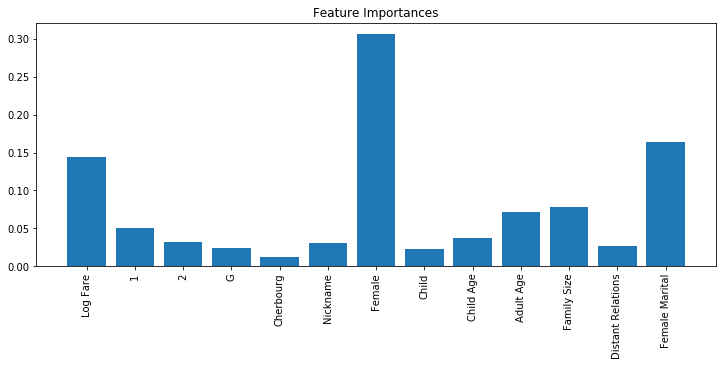

In [151]:
model = RandomForestClassifier(n_estimators=60,max_depth=6)
testmodel(reducedRF, model,ROC=False)
fig6, ax6 = plt.subplots(1)
ax6.bar(reducedRF, model.feature_importances_)
ax6.set_xticklabels(reducedRF, rotation=90)
ax6.set_title('Feature Importances')
fig6.set_size_inches((10,5))
fig6.tight_layout(pad=0.4, w_pad=0.5, h_pad=0.5)

The overall accuracy is a bit higher than the CV score, which indicates some overfitting. But the CV score is still the highest observed so far.

## Support Vector Machine

For the rest of the models, the reduced feature lists from the logistic regression, boosted tree, and random forest will be combined.

In [154]:
reducedgeneral = list(set(reducedRF+reducedLR+reducedRF))
print(reducedgeneral)

['1', 'Child Age', 'Nickname', 'EastAsian', 'Female Marital', 'Family Size', 'Female', 'Log Fare', 'G', 'Distant Relations', 'Italian', 'Adult Age', 'Cherbourg', 'Child', '2']


In [159]:
model = sklearn.svm.SVC()
optimize(model, reducedgeneral, {'gamma':[0.001, 0.01, 0.1, 1],'C':[1, 10, 100],'kernel':['rbf','linear']})

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
0.8619528619528619
[0.92714026 0.75730994]
[0.8597973  0.86622074]


Accuracy: 0.8619528619528619
Precision: 0.8662207357859532
Recall: 0.7573099415204678
ROC AUC: 0.8422250982647876
CV score: 0.8252525252525252


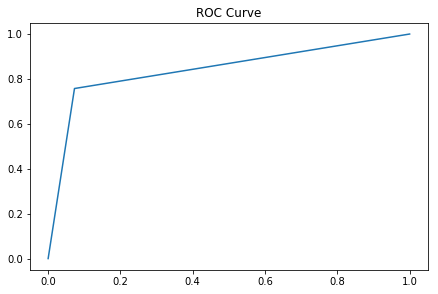

In [162]:
model = svm.SVC(kernel='rbf',gamma=0.1,C=10)
fpr,tpr = testmodel(reducedgeneral,model)
fig6, ax6 = plt.subplots(1)
ax6.plot(fpr,tpr)
ax6.set_title('ROC Curve')
fig6.tight_layout(pad=0.4, w_pad=0.5, h_pad=0.5)

Once again, a little overfitting is observed.

## k Nearest Neighbors

In [164]:
model = KNeighborsClassifier()
optimize(model, reducedgeneral, {'n_neighbors':[5,7,10,12,15]})

{'n_neighbors': 12}
0.8237934904601572
[0.9143898  0.67836257]
[0.82026144 0.83154122]


In [170]:
optimize(model, reducedgeneral, {'n_neighbors':[6,7,8,9,10,11,12,13,14,15]})

{'n_neighbors': 8}
0.8428731762065096
[0.93624772 0.69298246]
[0.83037157 0.87132353]


In [180]:
model = KNeighborsClassifier(n_neighbors=8)
testmodel(reducedgeneral,model,ROC=False)

Accuracy: 0.8428731762065096
Precision: 0.8713235294117647
Recall: 0.6929824561403509
CV score: 0.8014590347923681


Overfitting is observed again, which is expected for this algorithm, since it relies on local data rather than the entire set.

## Linear Discriminant Analysis

Accuracy: 0.8383838383838383
Precision: 0.8132911392405063
Recall: 0.7514619883040936
ROC AUC: 0.8219969322212636
CV score: 0.8228956228956228


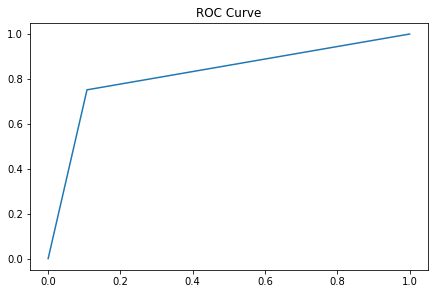

In [184]:
model = sklearn.discriminant_analysis.LinearDiscriminantAnalysis()
fpr, tpr = testmodel(reducedgeneral, model)
fig6, ax6 = plt.subplots(1)
ax6.plot(fpr, tpr)
ax6.set_title('ROC Curve')
fig6.tight_layout(pad=0.4, w_pad=0.5, h_pad=0.5)

There is not much overfitting with LDA, but accuracy is poor in general. The model may be too simple.

## Gaussian Naive Bayes

In [185]:
model = GaussianNB()
testmodel(reducedgeneral, model,ROC=False)

Accuracy: 0.8013468013468014
Precision: 0.7350427350427351
Recall: 0.7543859649122807
CV score: 0.7891133557800225


The overfitting is minimal for Naive Bayes as well, but the accuracy is the worst of all the algorithms, possibly because the assumption of independence of features does not hold.

## Prediction

Most of the models performed similarly except for kNN and Naive Bayes, which were a few percentage points lower in terms of cross validation. The best performing model in terms of overall accuracy and cross validation accuracy was the random forest model. Therefore this model is used to make the final predictions.

In [187]:
model = RandomForestClassifier(n_estimators=60,max_depth=6)
testmodel(reducedRF,model)
test['Survived']=model.predict(test[reducedRF])
test.head(20)

Accuracy: 0.8641975308641975
Precision: 0.867109634551495
Recall: 0.7631578947368421
ROC AUC: 0.8451490748729747
CV score: 0.8301907968574636


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,G,1,2,3,Constant,Log Fare,Child,Child Age,Adult Age,Fare x Female
0,892,0,3,"Kelly, James",male,0.577287,0,0,330911,0.117625,...,0,0,0,1,1,0.365549,0,0.0,0.585942,0.000000
1,893,1,3,"Wilkes, James",female,0.786449,1,0,363272,0.105168,...,0,0,0,1,1,0.348997,0,0.0,0.798240,0.883629
2,894,0,2,"Myles, Thomas Francis",male,1.037444,0,0,240276,0.145544,...,0,0,1,0,1,0.397607,0,0.0,1.052997,0.000000
3,895,0,3,"Wirz, Albert",male,0.451790,0,0,315154,0.130145,...,0,0,0,1,1,0.380686,0,0.0,0.458563,0.000000
4,896,1,3,"Hirvonen, Alexander",female,0.368125,1,1,3101298,0.184607,...,1,0,0,1,1,0.434152,0,0.0,0.373644,1.099234
5,897,0,3,"Svensson, Johan Cervin",male,0.234261,0,0,7538,0.138596,...,1,0,0,1,1,0.390182,0,0.0,0.237774,0.000000
6,898,1,3,"Connolly, Kate",female,0.501989,0,0,330972,0.114621,...,0,0,0,1,1,0.361704,0,0.0,0.509515,0.915801
7,899,0,2,"Caldwell, Albert Francis",male,0.435057,1,1,248738,0.435694,...,0,0,1,0,1,0.570830,0,0.0,0.441580,0.000000
8,900,1,3,"Abrahim, Joseph",female,0.301193,0,0,2657,0.108611,...,0,0,0,1,1,0.353738,0,0.0,0.305709,0.895633
9,901,0,3,"Davies, John Samuel",male,0.351392,2,0,A/4 48871,0.362828,...,1,0,0,1,1,0.541235,0,0.0,0.356660,0.000000
